## 5.1 生成式文本模型的评估

![Alt text](imgs/PixPin_2025-07-15_18-26-40.png)

这两段文本的token ID 如下：
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.039

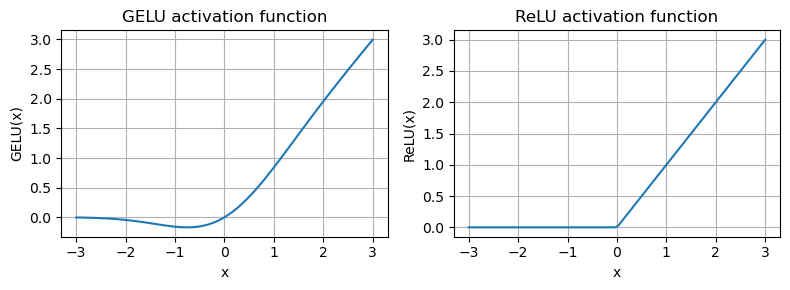

torch.Size([2, 3, 768])
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606
layers.0.0.weight has gradient mean of 0.2216978669166565
layers.1.0.weight has gradient mean of 0.20694100856781006
layers.2.0.weight has gradient mean of 0.3289698660373688
layers.3.0.weight has gradient mean of 0.2665731906890869
layers.4.0.weight has gradient mean of 1.3258538246154785

===== Self-Attention 结果 (含位置编码) =====

       x1        x2       x3       T1       T2       T3       T4       T5       T6       o1       o2       o3
 1.271471  0.690302 0.890005 0.315381 0.239435 0.105702 0.044346 0.066093 0.229044 1.273928 1.060221 0.435727
 1.459297  0.453853 0.660009 0.296198 0.233471 0.115046 0.054239 0.076627 0.224420 1.236005 1.028942 0.420495
 0.711120 -

In [1]:
%run ./4_model_for_gpt.ipynb

In [2]:
import torch
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,        #A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,             #B
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_porj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

我们通过前一章节中介绍的 generate_text_simple 函数来使用 GPTmodel 实例，同时引入了两个实用函数：text_to_token_ids 和token_ids_to_text。这些函数简化了文本与 token 表示之间的转换，本章中我们将多次使用这种技术。图 5.3 可以帮助我们更清楚地理解这一过程。

![Alt text](imgs/PixPin_2025-07-15_18-38-56.png)

图 5.3 展示了使用 GPT 模型生成文本的三个主要步骤。首先，分词器将输入文本转换为一系列 token ID（在第 2 章中已有讨论）。然后，模型接收这些 token ID 并生成对应的 logits（即词汇表中每个 token 的概率分布，具体见第 4 章）。最后，将 logits 转换回 token ID，分词器将其解码为可读的文本，完成从文本输入到文本输出的循环。

In [25]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 5.1.2 文本生成损失的计算

![Alt text](imgs/PixPin_2025-07-15_18-59-38.png)


In [4]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])    # "I really like"]
# Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [107, 588, 11311]]) # " really like chocolate"]

In [5]:
with torch.no_grad():                  #A
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape)

#A 禁用梯度跟踪，因为我们尚未进行训练

torch.Size([2, 3, 50257])


第一个数字 2 表示输入中的两个样本（行），即批次大小。第二个数字 3 表示每个样本包含的 token 数量。最后一个数字表示嵌入维度的大小，通常由词汇表大小决定，前面章节已讨论。

通过 softmax 函数将 logits 转换为概率后，第 4 章的 generate_text_simple 函数会将概率得分进一步转换回文本，这一过程在图 5.4 的步骤 3 到步骤 5 中进行了展示。

In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
#When we decode these tokens, we find that these output tokens are quite different from the target tokens we want the model to generate:

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


文本评估过程的一部分（如图 5.5 所示）是衡量生成的 token 与正确预测目标之间的差距。本章后面实现的训练函数将利用这些信息来调整模型权重，使生成的文本更接近（或理想情况下完全匹配）目标文本。

换句话说，模型训练的目标是提高正确目标 token ID 所在位置的 softmax 概率，如图 5.6 所示。接下来的部分中，我们还会将该 softmax 概率作为评价指标，用于对模型生成的输出进行数值化评估：正确位置上的概率越高，模型效果越好。

![Alt text](imgs/PixPin_2025-07-15_19-05-37.png)

In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print(f"Text 1: {target_probas_1}")

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4514e-05, 3.1054e-05, 1.1567e-05])
Text 2: tensor([3.9085e-05, 5.6737e-05, 4.7620e-06])


![Alt text](imgs/PixPin_2025-07-15_19-36-39.png)

In [9]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5045, -10.3798, -11.3674, -10.1498,  -9.7771, -12.2549])


> [!TIP]
>
> **个人思考：** 在继续接下来的计算之前，我们首先来探讨一下，对数在损失函数的应用中到底有什么作用。
>
> 1. **为什么要用概率的对数**
>
>    在 LLM 中，概率得分通常是小于1的数（例如0.1、0.05等），直接用这些数进行计算和优化可能会面临一些问题。比如，如果多个概率相乘，结果会变得非常小，甚至接近0。这种情况称为“数值下溢”（Numerical Underflow），可能导致计算不稳定。
>
>    假设我们有三个概率值，分别为0.2、0.1和0.05。如果我们计算这些值的乘积，结果是：
>
>    $$0.2×0.1×0.05=0.001$$
>
>    这个值非常小，尤其在深度学习或概率模型中，我们通常会有成千上万个概率需要相乘，这样会导致最终的乘积接近0甚至为0，造成数值计算的不稳定性。
>
>    如果我们对这些概率值取对数，然后相加，而不是直接相乘，我们可以避免这个问题。例如，对这三个值取自然对数（logarithm）后再相加：
>
>    $$ln(0.2)+ln(0.1)+ln(0.05)≈−1.6094+(−2.3026)+(−2.9957)=−6.9077$$
>
>    虽然这个和也是负数，但它不会像直接相乘的结果那样接近于0，避免了数值下溢的问题。**对数的累加性质**允许我们将原本的累乘操作转换为累加，使得计算更加稳定和高效。
>
>
>
> 2. 对数概率在损失函数中的作用**
>
>    GPT模型训练的目标是最大化正确目标 token 的概率，通常，我们会使用交叉熵损失来衡量模型预测与实际目标之间的差异。对于一个目标 token 序列 y=(y1,y2,…,yn)，GPT会生成一个对应的预测概率分布 P(y∣x)，其中 x 是模型的输入。
>
>    **交叉熵损失的公式：**
>
>    在计算交叉熵损失时，我们希望最大化模型分配给每个正确目标token的概率。交叉熵损失的数学公式为：
>
>    $$\text { Loss }=-\sum_{t=1}^{T} \ln P\left(y_{t} \mid x, \theta\right)$$
>
>    其中：
>
>    + T 是序列长度
>    + y<sub>t</sub> 是在位置 ttt 上的目标token
>    + P(y<sub>t</sub>∣x,θ) 是模型在参数 θ 下对目标token y<sub>t</sub>  的条件概率
>
>    在公式中，对每个token的概率 P(y<sub>t</sub>∣x,θ)  取对数，将乘积形式的联合概率转换为求和形式，有助于避免数值下溢，同时简化优化过程。


In [10]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.5722)


训练的目标就是通过更新模型权重，使平均对数概率尽可能接近 0（将在 5.2 节中实现）。

然而，在深度学习中，常见做法并不是直接将平均对数概率推向 0，而是通过将负平均对数概率降低至 0 来实现。负平均对数概率就是平均对数概率乘以 -1，这与图 5.7 的第 6 步相对应：

In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.5722)


在这里，PyTorch 非常实用，因为它内置的 cross_entropy 函数已经自动处理了图 5.7 中的 6 个步骤。

> [!NOTE]
> **交叉熵损失**
>
> 本质上，交叉熵损失是在机器学习和深度学习中一种常用的度量方法，用于衡量两个概率分布之间的差异——通常是标签的真实分布（此处为数据集中的 token）和模型的预测分布（例如，LLM 生成的 token 概率）。
>
> 在机器学习，特别是 PyTorch 等框架中，cross_entropy 函数用于计算离散输出的损失，与模型生成的 token 概率下的目标 token 的负平均对数概率类似。因此，cross entropy 和负平均对数概率这两个术语在计算上有关联，实践中经常互换使用。

In [12]:
print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


可以看出logits是三维张量而targets是二维张量，因此在计算交叉熵损失函数时，需要将这些张量展平。

In [13]:
logits_flat = logits.flatten(0,1)   ## 折叠第 0、1 维
targets_flat = targets.flatten()    # 折叠所有维度

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


> [!NOTE]
> **为什么需要flatten**
> 在 NLP/CV 等序列或图像任务里，模型输出 logits 和标签 targets 常常带有 batch 维 和 序列 / 像素位置维。
>
> - 例如语言模型：logits 形状通常是 [batch_size, seq_len, vocab_size]；targets 形状是 [batch_size, seq_len]。
>
> - PyTorch 的 nn.CrossEntropyLoss（以及 F.cross_entropy）只接受
> 
>     - 输入：[N, C] —— N 个样本，每个样本 C 个类别得分
> 
>     - 目标：[N] —— N 个类别索引
> 
> 因此，要先把 batch 维 与 时间/空间维 折叠在一起得到 “N = batch_size × seq_len” 条样本，再送进 loss。

| 张量        | 原始形状        | 调用后形状                                | 为什么这样折叠                                  |
| --------- | ----------- | ------------------------------------ | ---------------------------------------- |
| `logits`  | `[B, L, V]` | `[B × L, V]` (`flatten(0,1)` 只合并前两维) | 保留 **最后一维 V (vocab\_size)** 作为 **类别维 C** |
| `targets` | `[B, L]`    | `[B × L]`  (`flatten()` 合并所有维)       | 目标只需给出类别索引，因此变成一维 **\[N]**               |


In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("loss is: ", loss)
perp = torch.exp(loss)
print(f"Perplexity is {perp}")

loss is:  tensor(10.5722)
Perplexity is 39035.4921875


> [!NOTE]
> **Perplexity**
>
> Perplexity（困惑度）是交叉熵 H 的指数形式
>
> ```Perplexity``` 是一种经常与交叉熵损失一起使用的指标，用于评估语言建模等任务中的模型表现。它能够以更具可解释性的方式，帮助理解模型在预测下一个 token 时的*不确定性*。
>
> Perplexity 常用于衡量*模型预测的概率分布与数据集中词的实际分布的接近程度*。类似于损失函数，Perplexity的值越低，表示模型预测越接近真实分布。
>
> Perplexity可通过 perplexity = torch.exp(loss) 计算，对先前计算的损失值应用此公式将返回 tensor(39035.4921875)。
>
> Perplexity通常比原始损失值更具可解释性，因为它表示了模型在每一步生成中，对有效词汇量的不确定程度。在这个例子中，Perplexity可以理解为模型在它赋予正确 token 的平均概率仅约等于 1/39 035.

### 5.1.3 计算训练集和验证集的损失

为了计算训练集和验证集上的损失（如图 5.8 所示），我们使用了一个非常小的文本数据集，即伊迪丝·华顿的短篇小说《判决》，我们在第 2 章中已对此文本进行过处理。选择公共领域的文本可以避免任何关于使用权的担忧。此外，我们选择小数据集的原因在于，它允许代码示例在普通笔记本电脑上运行，即使没有高端 GPU 也能在几分钟内完成，这对于教学尤为有利。

In [15]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [16]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


![Alt text](imgs/PixPin_2025-07-15_20-50-22.png)

出于可视化的需要，图 5.9 将最大长度设置为 6。然而，在实际数据加载器中，我们会将最大长度设置为 LLM 支持的 256 个 token 的上下文长度，使得模型在训练时可以看到更长的文本。

> [!NOTE]
> **处理变长输入的训练**
>
> 在训练模型时，我们可以使用大小相似的数据块来保证训练过程的简便和高效。然而，在实践中，使用变长的输入进行训练往往有助于提升 LLM 的泛化能力，使其在应用时能够适应不同类型的输入。

In [17]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
print(f"training data is: {train_data}\n------------------------\nval_data is: {val_data}")

training data is: I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well

In [18]:
%run ./2processingtxt.ipynb

Total number of character:  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g
['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']
['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']
['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']
['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']
4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in', 'the', 'height', 'of', 'his', 'glory', ',', 'he', 'had', 'dropped', 'his', 'painting', ',', 'married', 'a', 'rich', 'widow', ',', 'and', 'established', 'himself']
1130
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 

In [24]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [20]:
print("Train loader:")
for x, y in train_loader:
    print(f"input data is {x.shape}, target data is {y.shape}")
print("-----------------------------")
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
-----------------------------

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [21]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [22]:
# Listing 5.2 Function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)                                    #A
    else:
        num_batches = min(num_batches, len(data_loader))                  #B
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()                                     #C
        else:
            break
    return total_loss / num_batches                                       #D


#A 如果没有指定批次数，将自动遍历所有批次
#B 若批次数超过数据加载器的总批次数，则减少批次数使其与数据加载器的批次数相匹配
#C 每个批次的损失求和
#D 对所有批次的损失取平均值

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #A
print(f"device is {device}")
model.to(device)
with torch.no_grad():                                                 #B
    train_loss = calc_loss_loader(train_loader, model, device)        #C
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)


#A 如果你的设备配备了支持 CUDA 的 GPU，LLM 将自动在 GPU 上进行训练，无需更改代码
#B 因为当前不在训练，为提高效率，关闭梯度跟踪
#C 通过 device 设置确保数据与 LLM 模型加载到同一设备上

device is cpu
Training loss: 10.987385114034018
Validation loss: 10.980905532836914


## 5.2 训练 LLM

![Alt text](imgs/PixPin_2025-07-17_14-37-03.png)

图 5.11 中的流程图展示了一个典型的 PyTorch 神经网络训练流程，我们用它来训练大语言模型（LLM）。流程概述了 8 个步骤，从迭代各个 epoch 开始，处理批次数据、重置和计算梯度、更新权重，最后进行监控步骤如打印损失和生成文本样本。如果你对使用 PyTorch 如何训练深度神经网络不太熟悉，可以参考附录 A 中的 A.5 至 A.8 节。

In [26]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []        #A 初始化用于记录损失和已处理 token 数量的列表
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):     #B 开始主训练循环
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                               #C 重置上一批次的损失梯度
            loss = calc_loss_batch(input_batch= input_batch, 
                                   target_batch= target_batch,
                                   model=model,
                                   device=device)
            loss.backward()                                     #D 计算损失梯度
            optimizer.step()                                    #E 使用损失梯度更新模型权重(用 AdamW 公式更新权重)
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:                    #F 可选的评估步骤(例子里 eval_freq=5，即 每 5 个 batch 做一次评估。)
                train_loss, val_loss = evaluate_model(model=model,
                                                      train_loader=train_loader,
                                                      val_loader=val_loader,
                                                      device=device,
                                                      eval_iter=eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        #G 每个 epoch 结束后打印示例文本       
        generate_and_print_sample(model=model,tokenizer=tokenizer, device=device, start_context=start_context)
    return train_losses,val_losses,track_tokens_seen


#evaluate_model 函数会在训练集和验证集上计算损失，同时确保模型处于评估模式，并在计算损失时禁用梯度跟踪和 dropout
#这一步对应了图5.11的步骤7
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(data_loader=train_loader, model=model,device=device,num_batches=eval_iter)
        val_loss = calc_loss_loader(data_loader=val_loader, model=model, device=device, num_batches=eval_iter)
    model.train()
    return train_loss,val_loss

#用于跟踪模型在训练过程中是否有改进。
def generate_and_print_sample(model, tokenizer,device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(text=start_context, tokenizer=tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple( model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
        decoded_text = token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()


> [!NOTE]
> **AdamW**
>
> Adam 优化器在深度神经网络训练中非常流行。然而在我们的训练循环中，我们选择了 ```AdamW 优化器```。AdamW 是 Adam 的一种变体，通过改进权重衰减方式，帮助```减少模型复杂度```，并通过**惩罚较大的权重**来**防止过拟合**。这样的调整使得 AdamW 能更有效地实现正则化，并提升模型的泛化能力，因此被广泛应用于大语言模型的训练中。

In [28]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)      #A
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

#A .parameters() 方法返回模型的所有可训练权重参数

Ep 1 (Step 000000): Train loss 9.831, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.135, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.771, Val loss 7.049
Ep 2 (Step 000015): Train loss 6.497, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.581, Val loss 6.489
Ep 3 (Step 000025): Train loss 4.733, Val loss 6.389
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 5.286, Val loss 6.361
Ep 4 (Step 000035): Train loss 3.858, Val loss 6.255
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.669, Val loss 6.196
Every effort moves yo

根据训练过程中的输出结果，训练损失显著下降，从 9.558 降到 0.762，模型的语言能力大幅提升。在训练初期，模型仅能在起始上下文后添加逗号（如“Every effort moves you,,,,,,,,,,,,”）或重复单词“and”。而在训练结束时，模型能够生成符合语法的文本。

与训练集损失类似，我们可以看到验证集损失在开始时较高（9.856），随后在训练过程中下降。但它始终未能像训练集损失那样低，在第 10 个 epoch 后保持在 6.372。

> [!NOTE]
> 运行整体流程：
>
> 1. 第 1～4 个 batch：常规训练，不评估。
>
> 2. 第 5 个 batch（global_step=4 → %5==0）：
>     - 触发一次评估（各取 1 个 batch估损失），存储并打印。
>
> 3. 重复上述流程直到一个 epoch 完成。
>
> 4. 结束 epoch 后，执行一次采样，打印文本。
>
> 5. 进入下一个 epoch，循环直至 10 epoch 完成。
>
> 6. 函数返回三条曲线数据：train_losses、val_losses 和 tokens_seen，方便你后续可视化或分析收敛情况。

> [!NOTE]
> **关键点回顾：**
>
> - 梯度生命周期：zero_grad() → forward → backward() → step()
>
> - 评估隔离：model.eval() + with torch.no_grad()，并在结束后 model.train()
> 
> - 监控指标：定期把损失与 token 计数存表，便于画图。
> 
> - 观测生成质量：每个 epoch 后直接打印一段续写，快速肉眼检查模型是否逐渐“学会”语言结构。

### 一、填空题（每空 1 分）

1. 在进入一个新的 batch 计算之前，我们调用 `optimizer.zero_grad()` 来清空上一批次累积的梯度。
2. `loss.backward()` 会根据当前 **前向传播** 构建的计算图，反向计算并填充各参数的 ```.grad()，梯度``` 属性。
3. `optimizer.step()` 的执行依赖于优化器内部保存的 ```梯度及其一阶/二阶动量（AdamW 会保存 m、v）```（提示：与一阶导数相关的数据）。
4. `model.eval()` 会关闭诸如 ```dropout``` 和 BatchNorm 中 running statistics 的更新，从而保证评估稳定。
5. 在 `evaluate_model()` 里包裹 `with torch.no_grad():` 的直接好处是 ```通过禁用梯度记录，节省显存空间``` 和 ```算力```（两点）。
6. `tokens_seen` 的累积值通过 `input_batch.numel()` 获得，含义是“当前 batch 输入张量的元素总数”。
7. 触发评估的判断条件是 `global_step % eval_freq == 0`；其中该变量在函数调用示例中被设置为 ```5,即每5步进行一次评估```。
8. `eval_iter` 控制评估阶段最多取 **多少个 batch** 进行损失平均，从而平衡速度与稳定性。
9. 生成示例文本时，调用 `generate_text_simple()` 的关键超参 `max_new_tokens=50` 表示最多再生成 50 个 token。
10. 在一次 epoch 结束后调用 `model.train()` 的目的，是将模型从 ```model.eval()``` 模式切回 ```model.train()``` 模式，为下一训练批次做准备。

---

### 二、简答题（每题 3 分）

11. 简述 **`with torch.no_grad()`** 与 **`requires_grad=False`** 的本质区别及各自典型使用场景。
    
| 方面   | `torch.no_grad()`                  | `requires_grad=False`                  |
| ---- | ---------------------------------- | -------------------------------------- |
| 作用域  | **上下文级**：进入 `with` 块后，所有张量计算都不记录梯度 | **张量级**：只影响某个张量本身是否需要梯度                |
| 典型场景 | - 推理 / 评估阶段节省显存与时间<br>- 手动参数拷贝、统计  | - 冻结部分网络（如特征提取器）<br>- 处理仅作输入、永不反传的辅助张量 |
| 互补关系 | `no_grad()` 可以临时覆盖一切；离开后自动恢复       | 需要长期冻结就改 `requires_grad`，省去每次包上下文      |


12. 如果把 `eval_iter` 从 `1` 调大到 `len(val_loader)`，对评估曲线的 **平滑度** 与 **训练速度** 分别有什么影响？
    
    - 平滑度：评估损失在整个验证集上平均，方差显著下降，曲线更平滑、可信。

    - 训练速度：每次评估要完整跑一次验证集，耗时增加（验证集越大越明显），训练 wall-time 变长。

    - 折中：可按资源选择中间值或每 N epoch 再全评估一次

13. 说明为什么在评估函数 `evaluate_model()` 里先 `model.eval()`、退出后再 `model.train()`，而不是只依赖 `torch.no_grad()`。
    
    - no_grad() 只关闭梯度，不影响 层的行为。

    - model.eval() 还会：

        - 关闭 Dropout 随机失活（否则推理不确定）；

        - 让 BatchNorm 使用累积均值/方差而不是当前 batch 统计。

    - 若少了 model.eval()，评估结果会有随机噪声，甚至偏差。

14. `generate_and_print_sample()` 会在终端打印一段续写文本。请说明这样的“定性监控”与仅依赖验证损失曲线相比，有哪些互补价值？
    
    - 定性检查：验证损失下降并不一定语句可读；打印可直接观察流畅度、重复率、逻辑性。

    - 早期诊断：能快速发现模式崩溃（如输出同一个 token）、字符集错误等。

    - 用户体验预览：最终模型多用于生成，肉眼示例最直观。

    - 补足指标盲区：语言建模 loss 与可读性/多样性并非严格单调。

15. 假设你的训练集非常大，而你仍保持 `eval_freq=5`。这会导致哪些潜在问题？列举至少两点并给出改进建议。
    
| 问题             | 说明                                   | 改进方案                                                |
| -------------- | ------------------------------------ | --------------------------------------------------- |
| **评估过于频繁**     | 每 5 batch 就停下来评估，I/O 与前向开销累积，整体训练效率低 | 根据总样本量改成 **按 token** 或 **按时间** 评估；如 `eval_freq=500` |
| **验证集过拟合监控失真** | 频繁抽小批次 (`eval_iter` 很小) 方差大；曲线抖动     | 增大 `eval_iter` 或只在 epoch 末全量评估                      |
| **日志过大**       | 打印/写文件过于密集                           | 调整打印频率、用 TensorBoard 之类按需记录                         |
| **GPU 占空稀释**   | 训练 → 评估不断切换，GPU pipeline 断裂          | 使用异步 eval（另一进程）或减少评估轮次                              |



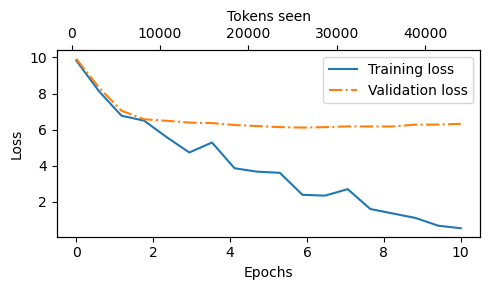

In [29]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny() #A
    ax2.plot(tokens_seen, train_losses, alpha=0) #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#A 创建与 y 轴共用的第二个 x 轴
#B 用于对齐刻度的隐藏图形

如图 5.12 所示，训练损失和验证损失在第一个 epoch 开始时都有所改善。然而，从第二个 epoch 之后，损失开始出现分歧。验证损失远高于训练损失，这表明模型在训练数据上出现了过拟合。我们可以通过搜索生成的文本片段（例如“The Verdict”文件中的片段：“quite insensible to the irony”）来确认模型逐词记住了训练数据。

这种记忆现象是预料之中的，因为我们使用了一个非常小的训练数据集，并且对模型进行了多轮训练。通常，我们会在更大的数据集上训练模型，并且只需训练一个 epoch 即可。

> [!NOTE]
> **个人思考**： 让我们基于 LLM 的原理来探讨一下为什么在一个较小的数据集上进行多轮训练，容易产生过拟合的现象？
>
> 1. 模型容量与数据集大小的匹配问题
>     - 大语言模型具有极高的参数容量，通常包含数百万甚至数十亿个参数。如此巨大的参数空间可以高度灵活地适应数据，使得模型能够“记住”每个样本的具体特征
>     - 当数据集很小时，模型没有足够的多样性去学习广泛的模式，而是倾向于学习每个数据点的细节。经过多轮训练，模型会逐渐“记住”小数据集中每个样本的特征，从而导致过拟合。
> 2. 多轮训练导致对数据集细节的过度学习
>     - 多轮训练意味着模型会反复接触相同的数据。这种重复使得模型逐渐适应数据集的特定模式，而不是学习一般化的规律。
>     - 每次训练迭代都会使模型在数据集上拟合得更好，因此在训练数据上损失逐渐减小，但由于缺少新的数据，模型无法学习到通用模式，只会进一步记住训练样本的细节。
> 3. 数据集的多样性不足
>     - 小数据集通常不能代表广泛的语言特征和分布，缺乏多样性。模型在小数据集上多轮训练，基本上是在有限的样本范围内形成模式，导致它对特定的训练样本依赖性过强。
>     - 这种缺乏多样性的训练会使模型偏向训练数据的分布，难以适应实际应用中广泛的输入数据。
> 4. 过拟合与模型泛化能力的矛盾
>     - 过拟合本质上是模型在训练数据上的表现优异，但在未见过的数据上表现较差。大语言模型的训练目标是提高其泛化能力，即能在更广泛的分布上生成有意义的文本。
>     - 当数据集非常小且多轮训练时，模型会对数据的细节和噪声进行过度拟合，这会导致模型在测试数据或实际应用中表现不佳，因为它无法应对新的、不同分布的输入。

![Alt text](imgs/PixPin_2025-07-17_17-02-44.png)

如图 5.13 所示，下一节将介绍适用于 LLM 的文本生成策略，以减少训练数据的记忆倾向，提升 LLM 生成文本的原创性。之后我们还会讨论权重的加载与保存，以及从 OpenAI 的 GPT 模型加载预训练权重。

## 5.3 通过解码策略控制生成结果的随机性

本节将介绍文本生成策略（也称为解码策略），用于生成更具原创性的文本。首先，我们将简要回顾前一章中的generate_text_simple函数，该函数已在本章前面用于生成和打印样本。然后，我们会讲解两种改进方法：```temperature scaling```和 ```top-k``` 采样。

In [31]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




如 5.1.2 节中所述，在生成过程中的每一步，都会选取词汇表中概率得分最高的 token 作为生成的 token。

> [!TIP]
> 这个步骤就是greedy最基础的方法，容易陷入局部最优，但是全局效果不佳。

### 5.3.1 Temperature scaling

之前，在 generate_text_simple 函数中，我们总是用 torch.argmax 选择概率最高的 token 作为下一个词，这也叫做贪心解码。为了生成更加多样化的文本，可以将 argmax 替换为一种从概率分布中进行采样的函数（这里，概率分布是指模型在每一步为每个词汇生成的概率得分）。

为了用具体的例子说明概率采样，我们将简要讨论下一词生成过程，并用一个非常小的词汇表来进行示例演示：

In [33]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

#接下来，假设给 LLM 一个初始上下文‘every effort moves you’，并生成下一个 token 的 logits 分数（如下所示）：

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

# 接着在 generate_text_simple 函数中，通过 softmax 函数将 logits 转化为概率，
# 并通过 argmax 函数得到生成的 token 的 ID，
# 最后通过逆词汇表将其映射回文本（可以回顾上一章）：

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


由于第四个位置的 logit 值最大，相应地，Softmax 归一化后的概率分数也在该位置上最大，因此生成的下一个词就是这个位置对应的词。

为了实现概率采样过程，现在可以用 PyTorch 中的 multinomial 函数代替 argmax：

In [39]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


输出依然是“forward”，这和之前一样。这是为什么？

 multinomial 函数根据每个 token 的概率得分来采样下一个 token。换句话说，“forward” 依然是最有可能的 token，因此大多数情况下会被 multinomial 选中，但并不是每次都选中。为了演示这一点，我们可以实现一个函数，重复采样 1000 次：

In [40]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


如果在生成函数 generate_and_print_sample 中将 ```argmax``` 替换为 ```multinomial```，模型有时会生成类似‘every effort moves you toward’、‘every effort moves you inches’和‘every effort moves you closer’这样的句子，而不是固定生成‘every effort moves you forward’。

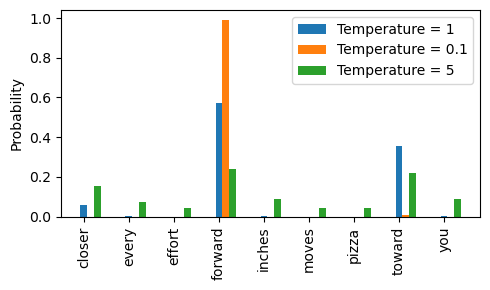

In [41]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)
#Temperatures greater than 1 result in more uniformly distributed token probabilities, and Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions. Let's illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:
temperatures = [1, 0.1, 5]             #A
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

#A 原始、较低和较高置信度


![Alt text](imgs/PixPin_2025-07-18_15-04-31.png)

当 temperature 取 1 时，logits 在传递给 softmax 函数之前会除以 1，计算概率得分。这意味着，temperature 为 1 时相当于不进行任何缩放。在这种情况下，模型将根据原始的 softmax 概率，通过 PyTorch 中的multinomial函数来选择 token。

如图 5.14 所示，当 temperature 设置为非常小的值（如 0.1）时，生成的分布会更加尖锐，因此multinomial函数几乎总是选择最可能的 token（这里是 ‘forward’），其行为接近 argmax 函数。相反，当 temperature 设置为 5 时，生成的分布更接近均匀分布，其他 token 被选中的频率更高。这种情况下，生成的文本多样性增加，*但也更可能出现无意义的内容*。例如，temperature 设置为 5 时，模型生成类似 ‘every effort moves you pizza’ 的文本概率大约为 4%。

> [!TIP]
>
> **个人思考：** 为什么 temperature 值非常小时，生成的概率分布会更加尖锐，越大时，概率分布会更加均匀，文中只是说了结论，没有说过程。
>
> **temperature** 参数被引入到 softmax 函数中，用于缩放 logits，从而控制输出的概率分布。当引入 temperature 后，softmax 函数的公式变为：
>
> $$ P\left(x_{i}\right)=\frac{\exp \left(\frac{z_{i}}{T}\right)}{\sum_{j} \exp \left(\frac{z_{j}}{T}\right)} $$
>
> 1. **当 T>1**
>    所有 logits 被除以 T，缩放后，差异变小。由于 exp 函数的敏感性较高，这意味着 logits 值的差异被“压平”，使得最优词的概率降低，而其他次优词的概率提高。输出的概率分布变得更加均匀，再结合multinomial函数，可以使生成结果更加多样化，但同时也降低了生成结果的确定性。
>
> 2. **当 T<1**
>
>    logits 除以 T 后会被放大，差异变得更加显著。softmax 函数会使最高 logit 对应的词语的概率变得更高，其他词语的概率更低。这导致输出的概率分布更加集中，模型更倾向于选择概率最大的词，从而提高了生成结果的确定性。

### 5.3.2 Top-k 采样

在 top-k 采样中，我们可以将采样限制在最有可能的前 k 个 token 内，并通过将其他 token 的概率设为零，将它们排除在选择之外，如图 5.15 所示。

![Alt text](imgs/PixPin_2025-07-18_15-19-28.png)


In [42]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [43]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],       #A 识别出小于 top 3 最小值的 logits
    input=torch.tensor(float('-inf')),                  #B 将这些较小的 logits 赋值为负无穷大
    other=next_token_logits                             #C 保留所有其他 token 的原始 logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [44]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [50]:
def generate(model, idx, max_new_tokens, context_size, temperature = 1.0, top_k = None, eos_id = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]

        if top_k is not None:
            top_logits, _ = torch.topk(logits,top_k)
            min_val = top_logits[:,-1]
            logits  = torch.where(
                logits < min_val,   #condition
                torch.tensor(float('-inf')).to(logits.device),  #当 condition 为 True 时选用的值
                logits                                          #当 condition 为 False 时选用的值
            )

        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(logits,dim=-1,keepdim=True)
    
        if eos_id is not None and (idx_next == eos_id).all():
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

`idx_cond = idx[:, -context_size:]` 这一行的作用可以拆成两点理解：

1. **切片语法**

   * `:` 表示保留第一维（batch 维）的全部样本；
   * `-context_size:` 表示在第二维（序列维）上只取**最后 `context_size` 个 token**。
     因此，`idx_cond` 的形状是 **`(batch_size, context_size)`**。

2. **为什么只取最后 `context_size` 个 token？**

   * **符合模型的固定上下文窗口** GPT-类模型在一次前向传播里只能看到有限长度（`context_size`）的历史；如果 `idx` 已经比这个窗口长，就必须裁掉旧的部分。
   * **节省计算** 即便模型允许更长序列，把全部历史都送进去也会让计算量与显存线性增大，而预测下一个 token 只需要最近 `context_size` 个 token 的信息即可。
   * **保持自回归一致性** 生成时我们不断把新 token 拼到 `idx`，长度逐步增长；每轮只拿末尾窗口喂模型，既保证了可见历史，又避免超出最大长度。

> 简单例子
>
> ```python
> # 假设 context_size = 4
> idx = tensor([[ 12,  27,  98,   6,  45,   3]])
> # 序列长度已是 6，大于 4
> idx_cond = idx[:, -4:]   # ==> [[98,  6, 45,  3]]
> ```
>
> 这样模型只会看到 `[98, 6, 45, 3]`，然后输出对应的下一个 token 概率分布。


`logits = logits[:, -1, :]` 的作用是 **把模型输出中“最后一个时间步”的 logits 取出来**，理由与维度如下。

| 维度       | 原始 `logits` 形状 | 取切片后的值   | 含义                              |
| -------- | -------------- | -------- | ------------------------------- |
| 0（batch） | `:`            | 全保留      | 一次可并行生成多条序列                     |
| 1（序列长度）  | `-1`           | 只取最后一个位置 | 该位置对应 `idx_cond` 里最右侧 token 的预测 |
| 2（词表）    | `:`            | 全保留      | 对词表中每个 token 的得分                |

结果张量形状变成 **`(batch_size, vocab_size)`**。
这样做的原因：

1. **自回归生成只关心最后一步**
   输入 `[t₁, t₂, …, tₖ]` 时，模型会返回每个位置的预测分布，但要采样下一个 token 只需第 *k* 个位置的分布。
2. **节省后续运算**
   切掉序列维度后，只需对一个 `vocab_size` 向量做 softmax / top-k / temperature 缩放；既省显存也省算力。
3. **保持批处理**
   仍保留 batch 维，允许一次并行生成多条序列。

因此，这一行相当于对模型完整输出做了一个 **“聚焦”操作**：聚焦到最新时间步，用来决定接下来要附加到序列尾部的 token。


In [66]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=40,
    temperature=1.6
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen a hint a littleI was such
"Ah enough


**练习 5.2**

尝试不同的 temperature 和 top-k 设置。根据你的观察，你能想到哪些应用场景适合较低的 temperature 和 top-k 设置吗？反之，哪些应用场景适合较高的 temperature 和 top-k 设置？（建议在本章末加载 OpenAI 的预训练权重后，再次进行此练习）

> Top-k 采样和温度缩放是需要根据 LLM 以及输出中所需的 diversity 和随机性程度进行调整的设置。
> 
> 当使用相对较小的 top-k 值（例如，小于 10）并且温度设置为低于 1 时，模型的输出变得不那么随机，更具确定性。当我们希望生成的文本更具可预测性、连贯性，并且更接近基于训练数据的最可能结果时，这种设置非常有用。
> 
> 这种低 k 值和温度设置的应用包括生成正式文档或报告，在这些场景中，清晰度和准确性最为重要。其他应用示例包括技术分析或代码生成任务，在这些任务中，精确性至关重要。此外，问答和教育内容需要准确的答案，低于 1 的温度有助于实现这一点。
> 
> 另一方面，较大的 top-k 值（例如，范围在 20 到 40 之间）和高于 1 的温度值很有用，当使用 LLM 进行头脑风暴或生成创意内容（如小说）时。

---

**练习 5.3**

generate 函数有哪些不同的设置组合可以强制生成确定性行为，即禁用随机采样，使其输出始终一致，类似于 generate_simple 函数？

> 将 top_k 设置为 None 且不应用温度缩放；
> 
> 将 top_k 设置为 1。

## 5.4 在 PyTorch 中加载和保存模型权重

![Alt text](imgs/PixPin_2025-07-18_16-27-48.png)

推荐的做法是保存模型的 state_dict（状态字典），这是一个字典，用于将模型的每一层映射到其对应的参数上，可以通过 torch.save 函数来实现，代码如下所示：

In [67]:
torch.save(model.state_dict(), "model.pth")

In [68]:
# 使用 state_dict 保存模型权重后，可以将权重加载到新的 GPTModel 模型实例中，具体操作如下：
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

C:\Users\jacob\AppData\Local\Temp\ipykernel_13532\2279982525.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_porj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

如果计划稍后继续预训练模型（例如使用本章之前定义的 train_model_simple 函数），那么建议同时保存优化器状态。

AdamW 等自适应优化器会为每个模型参数存储额外信息。AdamW 使用历史数据动态调整每个模型参数的学习率。没有这些信息时，优化器会重置，模型可能无法有效学习，甚至无法正确收敛，进而失去生成连贯文本的能力。可以使用 torch.save 保存模型和优化器的状态，方法如下：

In [69]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [70]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

C:\Users\jacob\AppData\Local\Temp\ipykernel_13532\2526848825.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth")


## 5.5 从 OpenAI 加载预训练权重

OpenAI 公开了 GPT-2 模型的权重，使我们不必投入数十万甚至数百万美元自行在大规模语料上重新训练模型。

在本节的余下部分，我们将把这些权重加载到 GPTModel 类中，并利用该模型进行文本生成。这里的权重是指存储在 PyTorch 的 Linear 和 Embedding 层的 .weight属性中的权重参数（在训练模型时，我们可以通过model.parameters() 访问这些权重）。

在后续章节中，我们将复用这些预训练权重，对模型进行微调以用于文本分类任务，并遵循类似 ChatGPT 的指令。

请注意，OpenAI 最初使用 TensorFlow 来保存 GPT-2 的权重，因此在 Python 中加载这些权重需要安装 TensorFlow。另外，以下代码将使用进度条工具 tqdm 来跟踪下载进度，也需要提前安装。

In [71]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.19.0
tqdm version: 4.66.5


In [86]:
import sys, os
project_root = os.path.abspath('.')          # 如果 notebook 打开时工作目录是项目根
sys.path.append(os.path.join(project_root, 'chapter05'))

from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel


In [76]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json


model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [06:38<00:00, 1.25MiB/s]   


File already exists and is up-to-date: gpt2\124M\model.ckpt.index


model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 433kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 413kiB/s]  


In [77]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [78]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [79]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


![Alt text](imgs/PixPin_2025-07-18_17-30-33.png)

如图 5.17 所示，不同大小的 GPT-2 模型在总体架构上保持一致，但注意力头和 Transformer 模块等组件的重复次数以及嵌入维度大小有所不同。本章的剩余代码也会兼容这些更大的模型。

在将 GPT-2 模型的权重加载到 Python 后，我们还需要将这些权重从 settings 和 params 字典转移到 GPTModel 实例中：

In [80]:
# First, we create a dictionary that lists the differences between the different GPT model sizes, as explained in Figure 5.17:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# Suppose we are interested in loading the smallest model, "gpt2-small (124M)". We can use the corresponding settings from the model_configs table able to update our full-length GPT_CONFIG_124M we defined and used earlier throughout the chapter as follows:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [81]:
NEW_CONFIG.update({"context_length": 1024})

此外，OpenAI 在多头注意力模块的线性层中使用了偏置向量，以实现查询（query）、键（key）和值（value）矩阵的计算。偏置向量在现代 LLM 中已不再常用，因为它们对提升模型性能没有帮助，因而不再必要。然而，由于我们使用的是预训练权重，为了保持一致性，仍需启用这些偏置向量：

In [87]:
NEW_CONFIG.update({"qkv_bias": True})
# We can now use the updated NEW_CONFIG dictionary to initialize a new GPTModel instance:

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

我们首先来定义一个简单的assign工具函数，用于检查两个张量或数组（左侧和右侧）的维度或形状是否一致，并将右侧张量作为可训练的 PyTorch 参数返回：

In [88]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

下来，我们定义一个名为 load_weights_into_gpt 的函数，用于将 params 字典中的权重加载到 GPT 模型实例中：

In [89]:
# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享

在 load_weights_into_gpt 函数中，我们需要将 OpenAI 实现中的权重与自定义的 GPTModel 实现进行精确匹配。举个例子，OpenAI 将第一个 Transformer 模块的输出投影层权重存储在 params["blocks"][0]["attn"]["c_proj"]["w"] 中。而在我们的实现中，这个权重对应于 gpt.trf_blocks[b].att.out_proj.weight，其中 gpt 是一个 GPTModel 实例。

在开发 load_weights_into_gpt 函数时，由于 OpenAI 的命名规范和我们的略有不同，我们进行了大量的尝试。幸运的是，assign 函数会在张量维度不匹配时发出警告。此外，如果这个函数有错误，我们会发现生成的 GPT 模型无法生成连贯的文本，从而识别出问题。

我们暂时不在实际操作中尝试 load_weights_into_gpt，而是直接将 OpenAI 模型的权重加载到我们自己的 GPTModel 实例 gpt 中：

In [90]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [91]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


In [92]:
train_loss = calc_loss_loader(train_loader, gpt, device)
val_loss = calc_loss_loader(val_loader, gpt, device)

练习 5.5

使用 OpenAI 预训练权重的 GPT 模型在‘The Verdict’数据集上计算训练集和验证集的损失。

In [93]:
print(f"train loss is: {train_loss}")
print(f"val loss is: {val_loss}")

train loss is: 3.7547568480173745
val loss is: 3.559627056121826


主要的观察结果是，训练集和验证集的性能处于同一水平。这可能有多种解释。

当 OpenAI 训练 GPT-2 时，“The Verdict” 并非预训练数据集的一部分。因此，该模型并没有显式地过拟合训练集，并且在 “The Verdict” 的训练集和验证集部分上表现得同样出色。（验证集损失略低于训练集损失，这在深度学习中是不常见的。然而，这很可能是由于数据集相对较小而产生的随机噪声。在实践中，如果没有过拟合，训练集和验证集的性能预计大致相同。）

“The Verdict” 是 GPT-2 训练数据集的一部分。在这种情况下，我们无法判断模型是否过拟合训练数据，因为验证集也可能被用于训练。为了评估过拟合的程度，我们需要一个在 OpenAI 完成 GPT-2 的训练后生成的新数据集，以确保它不可能是预训练数据的一部分。


练习 5.6

建议读者尝试不同规模的 GPT-2 模型，例如最大规模的 1558M 参数模型，并与本章加载的 124M 模型的生成效果进行比较。

In [ ]:
hparams, params = download_and_load_gpt2(model_size="1558M", models_dir="gpt2")
model_name = "gpt2-xl (1558M)"